In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.signal import find_peaks
import seaborn as sns
import emd


/Users/nuzzo2/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:

class EMDAnalyzer:
    def __init__(self):
        self.data = None
        self.imfs = None
        self.residual = None
        
    def fetch_data(self, ticker, start='2020-01-01'):
        """Fetch and prepare price data"""
        df = yf.download(ticker, start=start)
        self.data = df['Adj Close'].values
        self.dates = df.index
        return self.data
    
    def perform_emd(self):
        """Perform EMD decomposition"""
        # Initialize EMD
        imf = emd.sift.sift(self.data)
        self.imfs = imf
        return self.imfs
    
    def analyze_imfs(self):
        """Analyze IMF characteristics"""
        analysis = {}
        
        for i in range(self.imfs.shape[1]):
            imf = self.imfs[:, i]
            # Calculate basic statistics
            analysis[f'IMF_{i}'] = {
                'variance': np.var(imf),
                'energy': np.sum(imf**2),
                'mean_period': self._estimate_period(imf)
            }
            
        return pd.DataFrame(analysis).T
    
    def _estimate_period(self, imf):
        """Estimate average period of IMF"""
        peaks, _ = find_peaks(imf)
        if len(peaks) > 1:
            return np.mean(np.diff(peaks))
        return np.nan
    
    def plot_decomposition(self, title='EMD Decomposition'):
        """Plot original signal and IMFs"""
        n_imfs = self.imfs.shape[1]
        fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(15, 3*(n_imfs + 1)))
        
        # Plot original signal
        axes[0].plot(self.dates, self.data, 'b', label='Original')
        axes[0].set_title('Original Price Series')
        axes[0].legend()
        
        # Plot IMFs
        for i in range(n_imfs):
            axes[i+1].plot(self.dates, self.imfs[:, i], 'g', label=f'IMF {i+1}')
            axes[i+1].set_title(f'IMF {i+1}')
            axes[i+1].legend()
        
        plt.tight_layout()
        plt.suptitle(title, y=1.02, fontsize=14)
        return fig
    
    def generate_trading_signals(self):
        """Generate trading signals based on IMF analysis"""
        signals = pd.DataFrame(index=self.dates)
        
        # Use first IMF for short-term signals
        short_term = self.imfs[:, 0]
        # Use sum of lower IMFs for trend
        trend = np.sum(self.imfs[:, 2:], axis=1)
        
        signals['Price'] = self.data
        signals['Short_term'] = short_term
        signals['Trend'] = trend
        
        # Generate signals
        signals['Signal'] = 0
        # Long when short-term crosses trend upward
        signals.loc[short_term > trend, 'Signal'] = 1
        # Short when short-term crosses trend downward
        signals.loc[short_term < trend, 'Signal'] = -1
        
        return signals
    
    def analyze_modes(self):
        """Analyze mode mixing and significance"""
        n_imfs = self.imfs.shape[1]
        
        # Compute energy and correlation matrix
        energy = np.zeros(n_imfs)
        corr_matrix = np.zeros((n_imfs, n_imfs))
        
        for i in range(n_imfs):
            energy[i] = np.sum(self.imfs[:, i]**2)
            for j in range(n_imfs):
                corr_matrix[i,j] = np.corrcoef(self.imfs[:, i], self.imfs[:, j])[0,1]
        
        # Normalize energy
        energy_ratio = energy / np.sum(energy)
        
        return energy_ratio, corr_matrix
    
    def plot_mode_analysis(self):
        """Plot mode analysis results"""
        energy_ratio, corr_matrix = self.analyze_modes()
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot energy distribution
        ax1.bar(range(len(energy_ratio)), energy_ratio)
        ax1.set_title('Energy Distribution across IMFs')
        ax1.set_xlabel('IMF Index')
        ax1.set_ylabel('Energy Ratio')
        
        # Plot correlation heatmap
        sns.heatmap(corr_matrix, ax=ax2, cmap='RdBu_r', center=0)
        ax2.set_title('IMF Correlation Matrix')
        
        plt.tight_layout()
        return fig



[*********************100%***********************]  1 of 1 completed



IMF Analysis:
          variance        energy  mean_period
IMF_0     7.096986  8.729880e+03     3.138462
IMF_1    12.971239  1.594278e+04     8.883212
IMF_2    50.022033  6.167117e+04    27.066667
IMF_3   114.672902  1.409796e+05    78.857143
IMF_4  7283.355419  1.024568e+07   111.666667
IMF_5  2990.914377  1.762612e+08          NaN


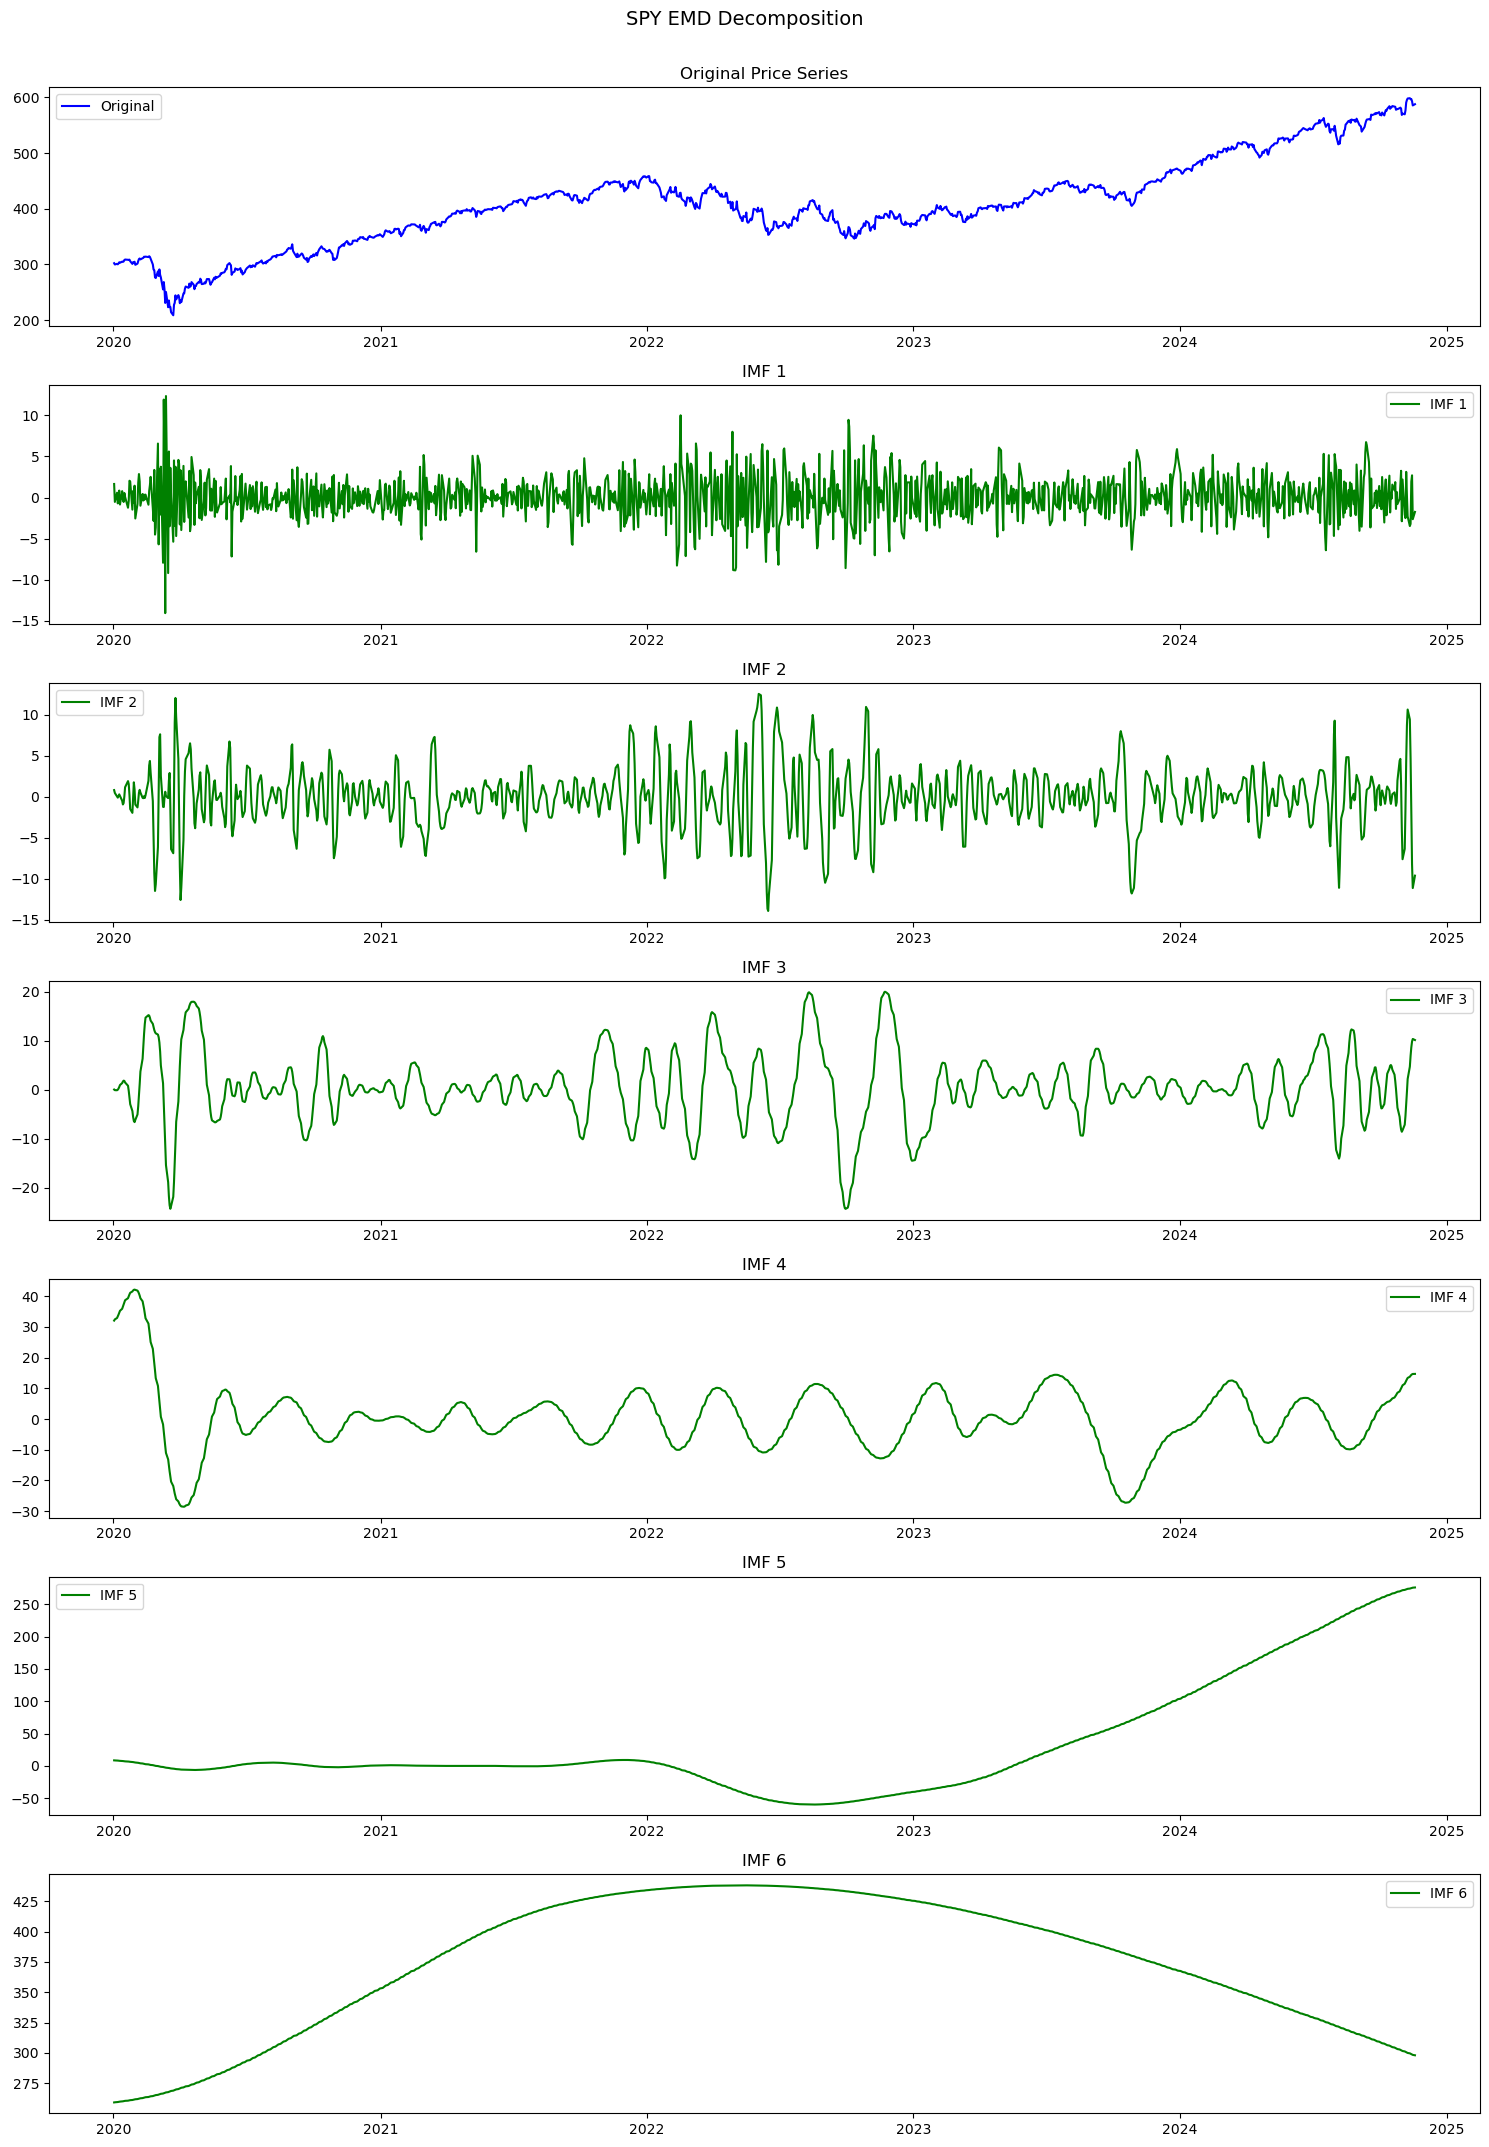

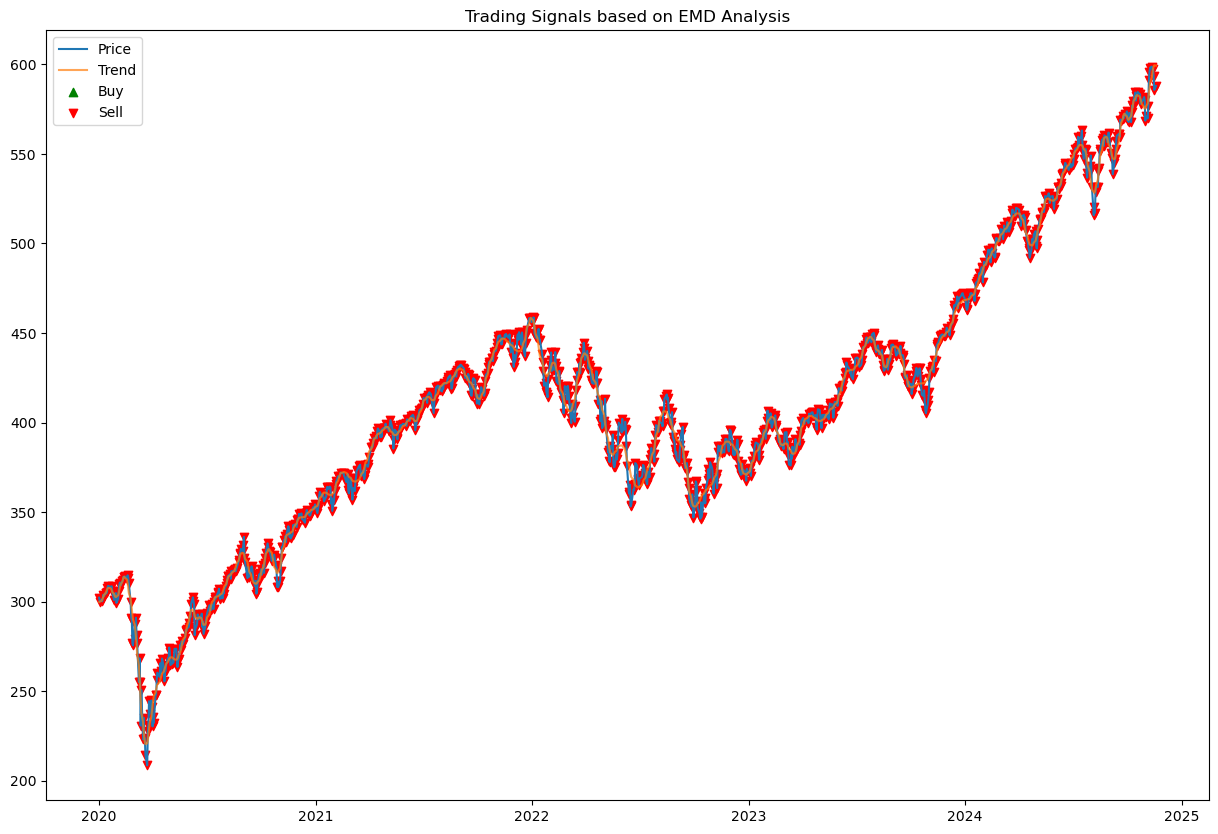

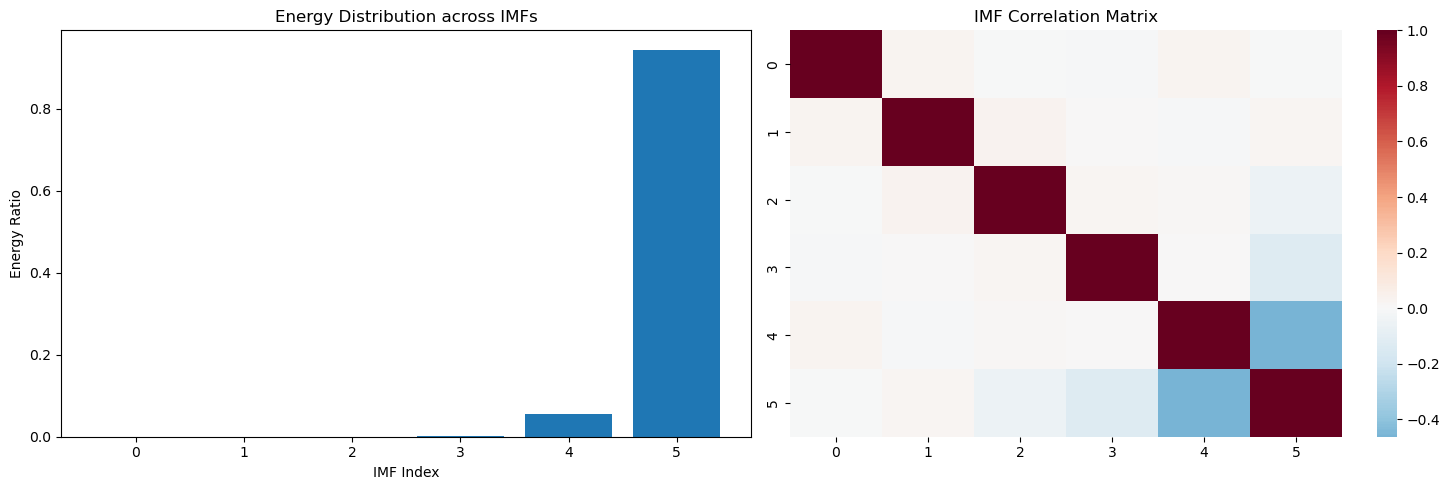

In [3]:

# Initialize analyzer
emd_analyzer = EMDAnalyzer()

# Fetch data
data = emd_analyzer.fetch_data('SPY')

# Perform decomposition
imfs = emd_analyzer.perform_emd()

# Analyze IMFs
imf_analysis = emd_analyzer.analyze_imfs()
print("\nIMF Analysis:")
print(imf_analysis)

# Plot decomposition
emd_analyzer.plot_decomposition("SPY EMD Decomposition")
plt.show()

# Generate and plot trading signals
signals = emd_analyzer.generate_trading_signals()

plt.figure(figsize=(15, 10))
plt.plot(signals.index, signals['Price'], label='Price')
plt.plot(signals.index, signals['Trend'], label='Trend', alpha=0.7)
plt.scatter(signals.index[signals['Signal'] == 1], 
            signals['Price'][signals['Signal'] == 1],
            marker='^', color='g', label='Buy')
plt.scatter(signals.index[signals['Signal'] == -1],
            signals['Price'][signals['Signal'] == -1],
            marker='v', color='r', label='Sell')
plt.legend()
plt.title('Trading Signals based on EMD Analysis')
plt.show()

# Plot mode analysis
emd_analyzer.plot_mode_analysis()
plt.show()